In [1]:
import torch
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
import scipy
from skimage.transform import resize
import numpy as np

/disk/student/adhara/anaconda3/envs/deepwave7/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/disk/student/adhara/anaconda3/envs/deepwave7/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/disk/student/adhara/anaconda3/envs/deepwave7/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/disk/student/adhara/anaconda3/envs/deepwave7/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
plot=True
# Load the true model
filename='../FWI_Ricardo/Marm151_401.mat'
mat=scipy.io.loadmat(filename)['vel']
mat = resize(mat,(151,200))
#mat = np.loadtxt('marmhard2.dat')
#mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
#RB Get model size
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.

print('vmin=',min1,'vmax=',max1,'vmed=',med,'vwidth=',wid)


vmin= 1500.0 vmax= 3550.000244140625 vmed= 2525.0001220703125 vwidth= 1025.0001220703125


In [3]:
GPU = 2
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)
plot=False # Plot Intermediate results
sigma=5.0   # Initial model smoothness  

# Inversion parameters
num_batches = 2
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 8
dx = 10
dt = 0.001
nt = 4001
num_shots = 18
num_receivers_per_shot = 200
# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

Logging hadn't been started.


In [4]:
# Set parameters
num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)


ny= 200 nz= 151 nt= 4001 dx= 10 freq= 8
shots= 18 recs/shot= 200 ds= 111.11111111111111 dr= 10.0


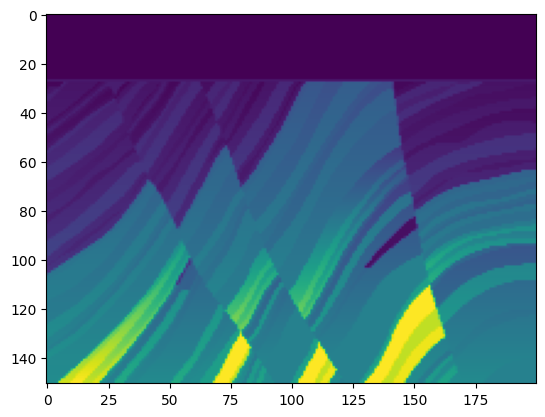

In [5]:
plt.imshow(mat)

In [14]:
num_shots = 5
n_shots = num_shots

n_sources_per_shot = 1
d_source = 20  # 20 * 4m = 80m
first_source = 2  # 10 * 4m = 40m
source_depth = 4  # 2 * 4m = 8m

n_receivers_per_shot = 30
d_receiver = 6  # 6 * 4m = 24m
first_receiver = 0  # 0 * 4m = 0m
receiver_depth = 4  # 2 * 4m = 8m

freq = 25
nt = 750
dt = 0.004
peak_time = 1.5 / freq

In [15]:
# source_locations
source_locations = torch.zeros(num_shots, 1, 2,
                               dtype=torch.long, device=device)
source_locations[..., 1] = source_depth
source_locations[:, 0, 0] = (torch.arange(n_shots) * d_source +
                             first_source)
# receiver_locations
receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
receiver_locations[..., 1] = receiver_depth
receiver_locations[:, :, 0] = (
    (torch.arange(n_receivers_per_shot) * d_receiver +
     first_receiver)
    .repeat(n_shots, 1))
#receiver_locations[:,:,0] = torch.linspace(10,180,n_receivers_per_shot).repeat(n_shots,1)

# source_amplitudes
source_amplitudes = (
    deepwave.wavelets.ricker(freq, nt, dt, peak_time)
    .repeat(n_shots, n_sources_per_shot, 1)
    .to(device)
)

In [16]:
np.shape(source_locations)

torch.Size([5, 1, 2])

In [17]:
source_locations[:,0,0]

tensor([ 2, 22, 42, 62, 82], device='cuda:2')

In [18]:
source_locations[:,0,1]

tensor([4, 4, 4, 4, 4], device='cuda:2')

In [19]:
receiver_locations[..., 1]

tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4]], device='cuda:2')

In [20]:
receiver_locations[..., 0]

tensor([[  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,  78,
          84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162,
         168, 174],
        [  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,  78,
          84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162,
         168, 174],
        [  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,  78,
          84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162,
         168, 174],
        [  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,  78,
          84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162,
         168, 174],
        [  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,  78,
          84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162,
         168, 174]], device='cuda:2')

In [21]:
#RB Convert models to PyTorch Tensors
v = torch.Tensor(mat).to(device) # Convert to a PyTorch Tensor
out = scalar(v, dx, dt, source_amplitudes=source_amplitudes,
             source_locations=source_locations,
             receiver_locations=receiver_locations,
             accuracy=4,
             pml_freq=freq)

RuntimeError: Locations must be within model.

In [ ]:
np.shape(receiver_locations)

In [ ]:
np.shape(out[-1])

In [ ]:
receiver_amplitudes = out[-1]
vmin, vmax = torch.quantile(receiver_amplitudes[0],
                            torch.tensor([0.05, 0.95]).to(device))
_, ax = plt.subplots(1, 2, figsize=(10.5, 7), sharey=True)
ax[0].imshow(receiver_amplitudes[0].cpu().T, aspect='auto',
             cmap='gray', vmin=vmin, vmax=vmax)
ax[1].imshow(receiver_amplitudes[0].cpu().T, aspect='auto',
             cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_xlabel("Channel")
ax[0].set_ylabel("Time Sample")
ax[1].set_xlabel("Shot")
plt.tight_layout()